In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate -U
!pip install transformers -U

In [3]:
import pandas as pd
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
from sklearn.model_selection import train_test_split

In [4]:
# Load the dataset
dataset_url = '/content/drive/MyDrive/deeplearning/teampro/dataset.txt'
with open(dataset_url, 'r', encoding='utf-8') as file:
    lines = [line.strip() for line in file]

In [5]:
sentences = []
labels = []
for line in lines:
    if '|' in line:
        parts = line.rsplit('|', 1)
        sentences.append(parts[0].strip())
        labels.append(int(parts[1].strip()))

data = pd.DataFrame({
    'sentence': sentences,
    'label': labels
})

In [6]:
# Split and Make Dataset
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)

In [16]:
# Tokenize Dataset
tokenizer = AutoTokenizer.from_pretrained('snunlp/KR-BERT-char16424')
def tokenize_data(data):
    encoded = tokenizer(
        data['sentence'],
        truncation=True,
        max_length=512
    )
    encoded['labels'] = data['label']
    return encoded

tokenized_train_dataset = train_dataset.map(tokenize_data, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_data, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/4660 [00:00<?, ? examples/s]

Map:   0%|          | 0/582 [00:00<?, ? examples/s]

Map:   0%|          | 0/583 [00:00<?, ? examples/s]

In [17]:
# Load Collator
collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding='longest'    # pad to longest sequence in batch
)

In [9]:
# Function to compute metrics
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    accuracy = accuracy_score(p.label_ids, preds)
    f1 = f1_score(p.label_ids, preds, average='weighted')
    return {'accuracy': accuracy, 'f1': f1}

In [14]:
# Load arguments
training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=10,
        weight_decay=.03,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        learning_rate=3e-5,
        evaluation_strategy='steps',
        eval_steps=300,
        save_strategy='steps',
        save_steps=300,
        logging_strategy='steps',
        logging_steps=500,
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        lr_scheduler_type='cosine',
        warmup_ratio=0.1,
        no_cuda=False

    )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
# Load & Train model

model = AutoModelForSequenceClassification.from_pretrained('snunlp/KR-BERT-char16424', num_labels=2)

model.config.dropout = 0.1

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    data_collator=collator,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at snunlp/KR-BERT-char16424 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1
300,No log,0.390122,0.840206,0.836283
600,0.440300,0.385877,0.859107,0.858576
900,0.440300,0.674410,0.878007,0.875438
1200,0.135100,0.828742,0.864261,0.863102
1500,0.042500,0.844558,0.874570,0.873499
1800,0.042500,0.926200,0.871134,0.870732
2100,0.012900,0.993130,0.865979,0.866593
2400,0.012900,1.013834,0.864261,0.863838
2700,0.004400,1.018532,0.865979,0.865647


TrainOutput(global_step=2920, training_loss=0.10918478667736053, metrics={'train_runtime': 971.9652, 'train_samples_per_second': 47.944, 'train_steps_per_second': 3.004, 'total_flos': 2150063377752240.0, 'train_loss': 0.10918478667736053, 'epoch': 10.0})

In [19]:
# Evaluate the final model on the test set
test_results = trainer.evaluate(tokenized_test_dataset)

print(f"Test Accuracy: {test_results['eval_accuracy']}")
print(f"Test F1 Score: {test_results['eval_f1']}")

Test Accuracy: 0.8404802744425386
Test F1 Score: 0.8348604266785409


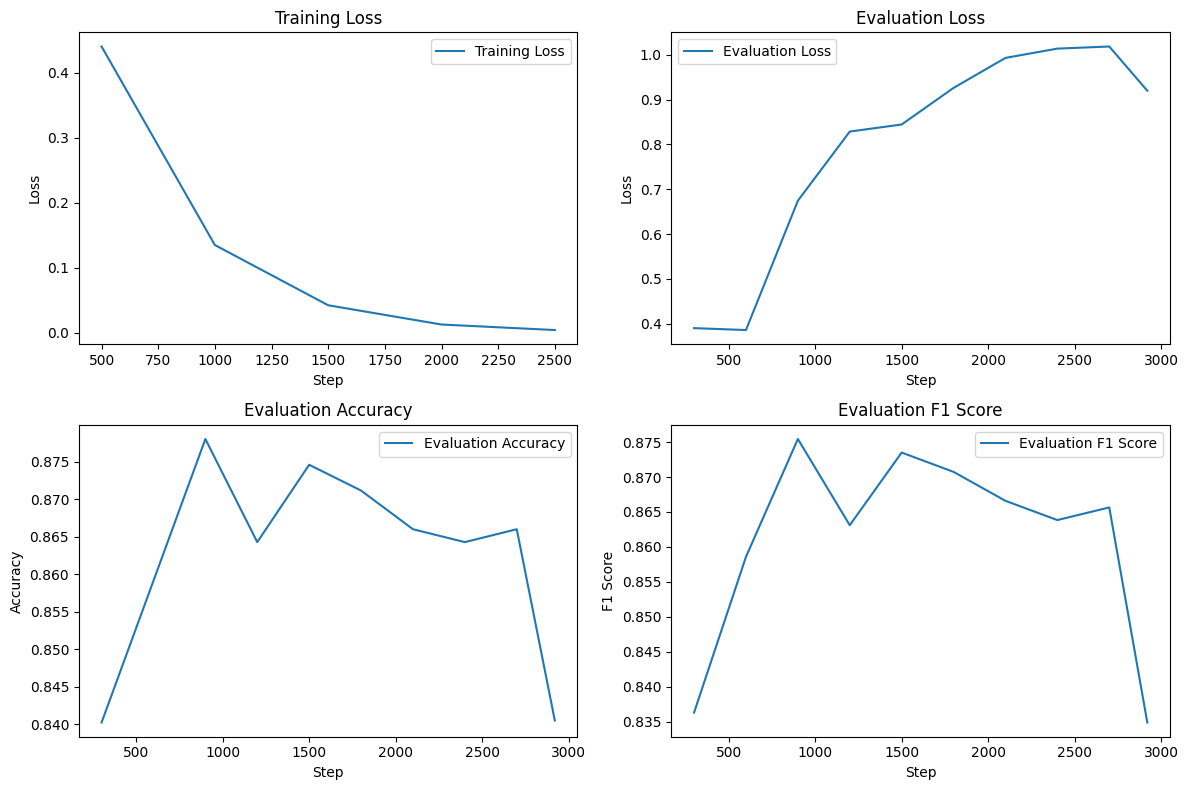

In [20]:
import matplotlib.pyplot as plt

# Fetching metrics from the trainer's logs
log_history = trainer.state.log_history

# Extracting values for plotting
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_accuracy = []
eval_f1 = []

for entry in log_history:
    if 'loss' in entry and 'step' in entry:
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])
    elif 'eval_loss' in entry:
        eval_steps.append(entry['step'])  # Ensure steps are logged with eval metrics
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry['eval_accuracy'])
        eval_f1.append(entry['eval_f1'])

# Creating the plots
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(train_steps, train_loss, label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(eval_steps, eval_loss, label='Evaluation Loss')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Evaluation Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(eval_steps, eval_accuracy, label='Evaluation Accuracy')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(eval_steps, eval_f1, label='Evaluation F1 Score')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('F1 Score')
plt.title('Evaluation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

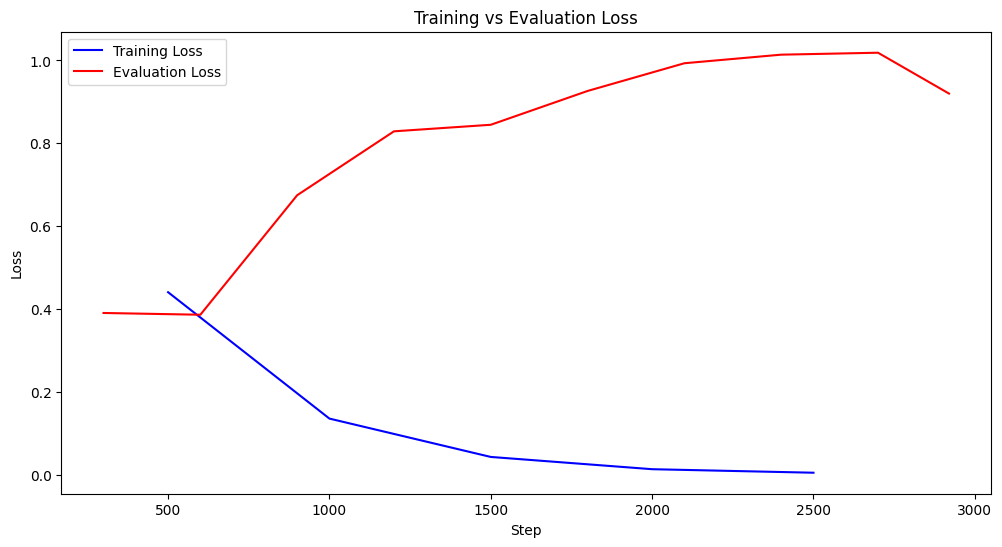

In [21]:
import matplotlib.pyplot as plt

# Fetching metrics from the trainer's logs
log_history = trainer.state.log_history

# Extracting values for plotting
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_accuracy = []
eval_f1 = []

for entry in log_history:
    if 'loss' in entry and 'step' in entry:
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])
    elif 'eval_loss' in entry:
        eval_steps.append(entry['step'])  # Ensure steps are logged with eval metrics
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry['eval_accuracy'])
        eval_f1.append(entry['eval_f1'])

# Plotting Loss (Training and Evaluation on the same graph)
plt.figure(figsize=(12, 6))

plt.plot(train_steps, train_loss, label='Training Loss', color='blue')
plt.plot(eval_steps, eval_loss, label='Evaluation Loss', color='red')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training vs Evaluation Loss')
plt.legend()
